In [109]:
import gpytorch
import torch
from itertools import product

In [110]:
torch.linspace(0, 1, 10)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [111]:
class ExactMIGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_text="RBF", weights=None):
        super(ExactMIGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.RBFKernel(active_dims=0) + gpytorch.kernels.MaternKernel(active_dims=1), num_dims=2)

    def forward(self, x):
        mean_x = self.mean_module(x)#sum([self.mean_module(xp) for xp in x])
        covar_x = self.covar_module(x)#sum([covar(xp) for xp, covar in zip(x, self.covar_module)])
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [112]:
X_SIZE = 10 

# data MUST be pairs of x_i values i.e. (x1, x2), (x1, x3), (x2, x3), etc.
train_x = torch.tensor(list(product(torch.linspace(0, 5, X_SIZE), torch.linspace(0, 5, X_SIZE))))
train_y = (torch.sin(train_x[:,0]) + torch.cos(train_x[:,1]))#.view(-1, 1)
print(train_x)
print(train_y)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
data_model = ExactMIGPModel(train_x, train_y, likelihood)

tensor([[0.0000, 0.0000],
        [0.0000, 0.5556],
        [0.0000, 1.1111],
        [0.0000, 1.6667],
        [0.0000, 2.2222],
        [0.0000, 2.7778],
        [0.0000, 3.3333],
        [0.0000, 3.8889],
        [0.0000, 4.4444],
        [0.0000, 5.0000],
        [0.5556, 0.0000],
        [0.5556, 0.5556],
        [0.5556, 1.1111],
        [0.5556, 1.6667],
        [0.5556, 2.2222],
        [0.5556, 2.7778],
        [0.5556, 3.3333],
        [0.5556, 3.8889],
        [0.5556, 4.4444],
        [0.5556, 5.0000],
        [1.1111, 0.0000],
        [1.1111, 0.5556],
        [1.1111, 1.1111],
        [1.1111, 1.6667],
        [1.1111, 2.2222],
        [1.1111, 2.7778],
        [1.1111, 3.3333],
        [1.1111, 3.8889],
        [1.1111, 4.4444],
        [1.1111, 5.0000],
        [1.6667, 0.0000],
        [1.6667, 0.5556],
        [1.6667, 1.1111],
        [1.6667, 1.6667],
        [1.6667, 2.2222],
        [1.6667, 2.7778],
        [1.6667, 3.3333],
        [1.6667, 3.8889],
        [1.6

In [113]:
gpytorch.means.ZeroMean()(train_x)
data_model(train_x)


MultivariateNormal(loc: torch.Size([100]))

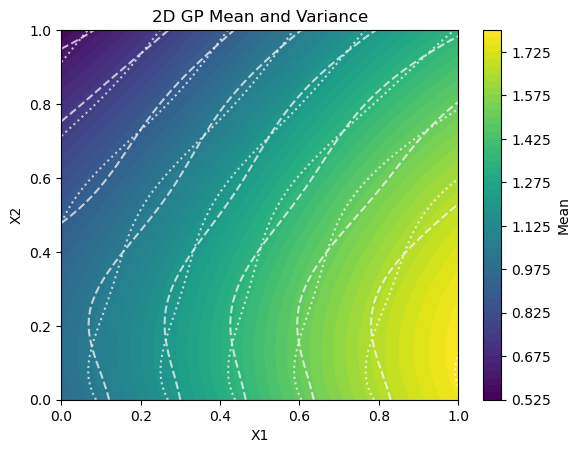

In [114]:
plot_2d_gp(data_model, likelihood, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, resolution=50)

In [115]:
zer = gpytorch.means.ZeroMean()
mean_x = sum([zer(xp) for xp in train_x.T])
mean_x.shape
covar_module = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.MaternKernel()]
covar_x = sum([covar(xp) for covar, xp in zip(covar_module, train_x.T)])
covar_x.evaluate()
#covar_x = sum([covar(xp) for xp, covar in zip(x, self.covar_module)])

tensor([[2.0000e+00, 1.6435e+00, 1.2461e+00,  ..., 2.3507e-04, 4.9751e-05,
         1.0264e-05],
        [1.6435e+00, 2.0000e+00, 1.6435e+00,  ..., 1.0752e-03, 2.3507e-04,
         4.9752e-05],
        [1.2461e+00, 1.6435e+00, 2.0000e+00,  ..., 4.7128e-03, 1.0752e-03,
         2.3507e-04],
        ...,
        [2.3507e-04, 1.0752e-03, 4.7128e-03,  ..., 2.0000e+00, 1.6435e+00,
         1.2461e+00],
        [4.9751e-05, 2.3507e-04, 1.0752e-03,  ..., 1.6435e+00, 2.0000e+00,
         1.6435e+00],
        [1.0264e-05, 4.9752e-05, 2.3507e-04,  ..., 1.2461e+00, 1.6435e+00,
         2.0000e+00]], grad_fn=<AddBackward0>)

In [116]:
with torch.no_grad(), gpytorch.settings.prior_mode(True):
    f_preds = data_model(train_x)
all_observations_y = f_preds.sample_n(5)

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [117]:
import matplotlib.pyplot as plt

def plot_2d_gp(model, likelihood, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, resolution=50):
    xx, yy = torch.meshgrid(
        torch.linspace(x_min, x_max, resolution), 
        torch.linspace(y_min, y_max, resolution)
    )
    test_x = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)

    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x))
        mean = preds.mean.reshape(resolution, resolution)
        lower, upper = preds.confidence_region()
        lower = lower.reshape(resolution, resolution)
        upper = upper.reshape(resolution, resolution)

    plt.figure()
    mean_contour = plt.contourf(xx.numpy(), yy.numpy(), mean.numpy(), levels=50, cmap='viridis')
    plt.colorbar(mean_contour, label='Mean')
    plt.contour(xx.numpy(), yy.numpy(), lower.numpy(), levels=10, linestyles='dotted', colors='white', alpha=0.7)
    plt.contour(xx.numpy(), yy.numpy(), upper.numpy(), levels=10, linestyles='dashed', colors='white', alpha=0.7)
    plt.title('2D GP Mean and Variance')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [139]:
def plot_3d_gp(model, likelihood, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, resolution=50):

    model.eval()
    likelihood.eval()

    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    xx, yy = torch.meshgrid(x_vals, y_vals)
    test_x = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)

    with torch.no_grad():
        preds = likelihood(data_model(test_x))
        mean = preds.mean.reshape(resolution, resolution)
        lower, upper = preds.confidence_region()
        lower = lower.reshape(resolution, resolution)
        upper = upper.reshape(resolution, resolution)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot mean surface
    ax.plot_surface(xx.numpy(), yy.numpy(), mean.numpy(), cmap='viridis', alpha=0.8)

    # Plot lower and upper surfaces
    ax.plot_surface(xx.numpy(), yy.numpy(), lower.numpy(), color='gray', alpha=0.2)
    ax.plot_surface(xx.numpy(), yy.numpy(), upper.numpy(), color='gray', alpha=0.2)

    ax.set_title('2D GP in 3D')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Mean and Variance Range')

    plt.show()


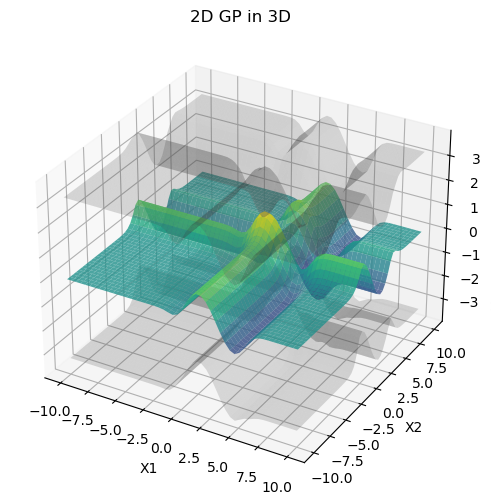

In [140]:
plot_3d_gp(data_model, likelihood, x_min=-10.0, x_max=10.0, y_min=-10.0, y_max=10.0, resolution=50)